# Using Tensorflow and Deep learning for Univariate Time Series Prediction

## Import packages

In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=b069eee7dc12e8ff6f3fc2ad20fb2a1998f8f6791cabe2b77960c9758e67469b
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import yfinance as yf


In [0]:
def plot_series(time, series, format='-' , start=0 , end=None):
  
  plt.plot(time[start:end], series[start:end] , format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

## Common functions

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def plot_loss(history):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  loss = history.history['loss']
  val_loss = history.history['val_loss']  
  accuracy = history.history['mae']
  val_accuracy = history.history['val_mae']

  n_epochs = len(loss)
  epochs = range(n_epochs) # Get number of epochs


  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
  axs[0][0].plot(epochs, accuracy, label='Training Accuracy')
  axs[0][0].plot(epochs, val_accuracy, label='Validation Accuracy')
  axs[0][0].legend()
  axs[0][0].set_title('Accuracy')

  axs[0][1].plot(epochs, loss, label='Training loss')
  axs[0][1].plot(epochs, val_loss, label='Validation Loss')
  axs[0][1].legend()
  axs[0][1].set_title('Loss')


  zoom_split = n_epochs - int(n_epochs / 7)
  zoomed_loss = loss[zoom_split:]
  zoomed_val_loss = val_loss[zoom_split:]
  zoomed_accuracy = accuracy[zoom_split:]
  zoomed_val_accuracy = val_accuracy[zoom_split:]

  zoomed_epochs = range(zoom_split,n_epochs)

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  axs[1][0].plot(zoomed_epochs, zoomed_accuracy, label='Training Accuracy')
  axs[1][0].plot(zoomed_epochs, zoomed_val_accuracy, label='Validation Accuracy')
  axs[1][0].legend()
  axs[1][0].set_title('Accuracy')

  axs[1][1].plot(zoomed_epochs, zoomed_loss, label='Training loss')
  axs[1][1].plot(zoomed_epochs, zoomed_val_loss, label='Validation Loss')
  axs[1][1].legend()
  axs[1][1].set_title('Loss')

  plt.figure()

## Prepare Data

In [9]:
data = yf.download('WMT', period='max')

[*********************100%***********************]  1 of 1 completed


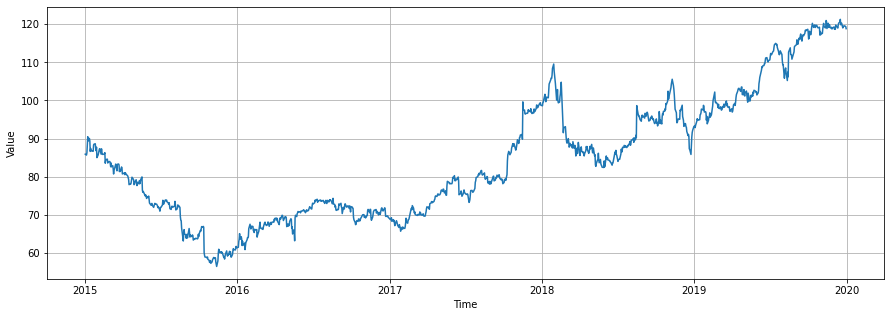

In [10]:
period = data.loc['2015-01-01':'2019-12-31']
series = period['Close'].to_numpy().ravel()
times = period.index.to_numpy().ravel()

fig = plt.figure(figsize = (15,5))
plot_series(times, series)

In [0]:
split_size = 1000
x_train = series[:split_size]
y_train = times[:split_size]

x_test = series[split_size:]
y_test = times[split_size:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## *2*. Buid a simple RNN model to train data 
The first Lambda layer will be used to help us with our dimensionality. 
The windowed_dataset function returnes a two-dimensional batches of Windows on the data, with the first being the **batch size** and the second the **number of timestamps**.


But an RNN expects three-dimensions; batch size, the number of timestamps, and the series dimensionality.With the Lambda layer, we can fix this without rewriting our Window dataset helper function. Using the Lambda, we just expand the array by one dimension. <u>By setting input shape to **none**</u>, we're saying that the model can take sequences of any length.


Similarly, if we scale up the outputs by 100, we can help training. The default activation function in the RNN layers is **tanH** which is the hyperbolic tangent activation. This outputs values between -1 and 1. Since the time series values are in that order usually in the 10s like 40s, 50s, 60s, and 70s, then scaling up the outputs to the same ballpark can help us with learning. We can do that in a Lambda layer too, we just simply multiply that by a 100.

For loss function the Huber is used which is a loss function that's less sensitive to outliers and as time series data can get a little bit noisy.\
it's worth giving it a shot.

## 3. Build a LSTM model

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule] , verbose=0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/100
4/4 [==============================] - 0s 42ms/step - loss: 63.9393 - mae: 64.4393 - lr: 1.0000e-08
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 60.9926 - mae: 61.4926 - lr: 1.1220e-08
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 59.7225 - mae: 60.2225 - lr: 1.2589e-08
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 58.4230 - mae: 58.9230 - lr: 1.4125e-08
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 56.8606 - mae: 57.3606 - lr: 1.5849e-08
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 55.0288 - mae: 55.5288 - lr: 1.7783e-08
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 52.9239 - mae: 53.4239 - lr: 1.9953e-08
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 50.5371 - mae: 51.0371 - lr: 2.2387e-08
Epoch 9

In the previous section, we build a model. The model for training the RNN contans two layers each with 40 cells.
- To tune the **learning rate**, a callback can be setted, which as can be seen here. Every epoch this just changes the learning rate a little so that it steps all the way from 1e-8 to  0.00089.
- For loss function the Huber is used which is a loss function that's less sensitive to outliers and as time series data can get a little bit noisy.\
it's worth giving it a shot.

If we run this for 100 epochs and measure the loss at each epoch, we will see that my optimum learning rate for stochastic gradient descent is between about 10e-5 and 10e-6. So I'm going to set it's 1.7e-06.

(1e-08, 0.0001, 0.0, 60.0)

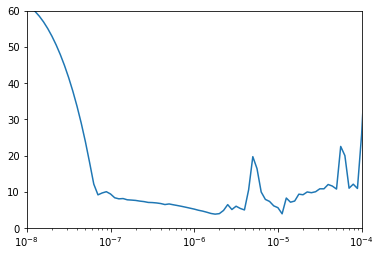

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])



In previous section, we tuned the learning rate and the stochastic gradient descent optimizer. So now, it's time to find number of epoch. After training for 500 epochs, I will get this chart, with an MAE on the validation set of about 6.35. It's not bad, but I wonder if we can do better. So here's the loss and the MAE during training with the chart on the right is zoomed into the last few epochs. As you can see, the trend was genuinely downward until a little after 400 epochs, when it started getting unstable. Given this, it's probably worth only training for about 400 epochs. When I do that, I get these results. That's pretty much the same with the MAE only a tiny little bit higher, but we've saved 100 epochs worth of training to get it. So it's worth it. A quick look at the training MAE and loss gives us this results. So we've done quite well, and that was just using a simple RNN. Let's see how we can improve this with LSTMs and you'll see that in the next video.

In [0]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500)
])


optimizer = tf.keras.optimizers.SGD(lr=1.7e-06, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set,epochs=500, verbose = 0 , validation_data=test_set)

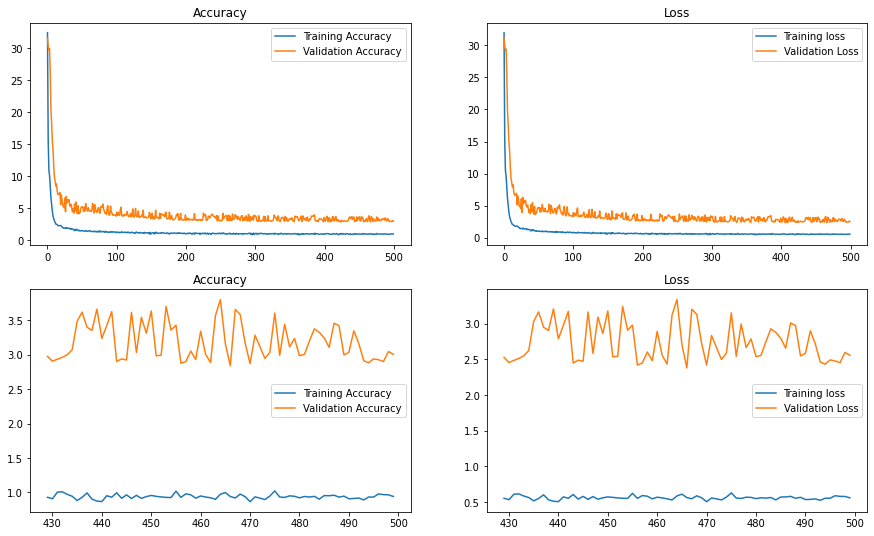

<Figure size 432x288 with 0 Axes>

In [51]:
plot_loss(history)

Network loss (MAE): : 3.0915978


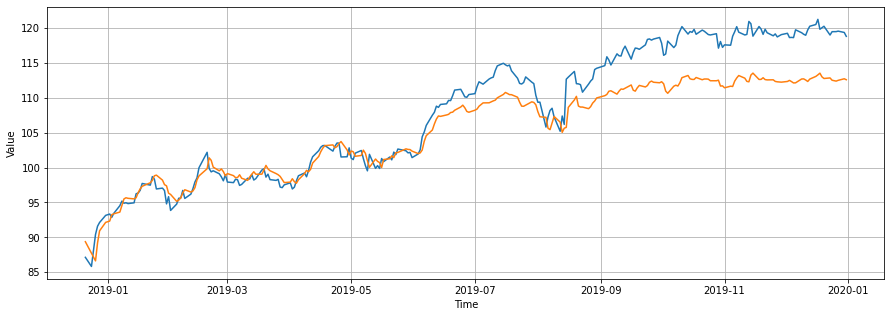

In [52]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = rnn_forecast[split_size - window_size:-1, -1, 0]


print("Network loss (MAE): :" , tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

# plot the prediction vs actual values
fig = plt.figure(figsize = (15,5))
plot_series(y_test, x_test)
plot_series(y_test, results)
plt.show()